Loading datasets...
Merging weight classes...
Generating Weight Class diagnostics...


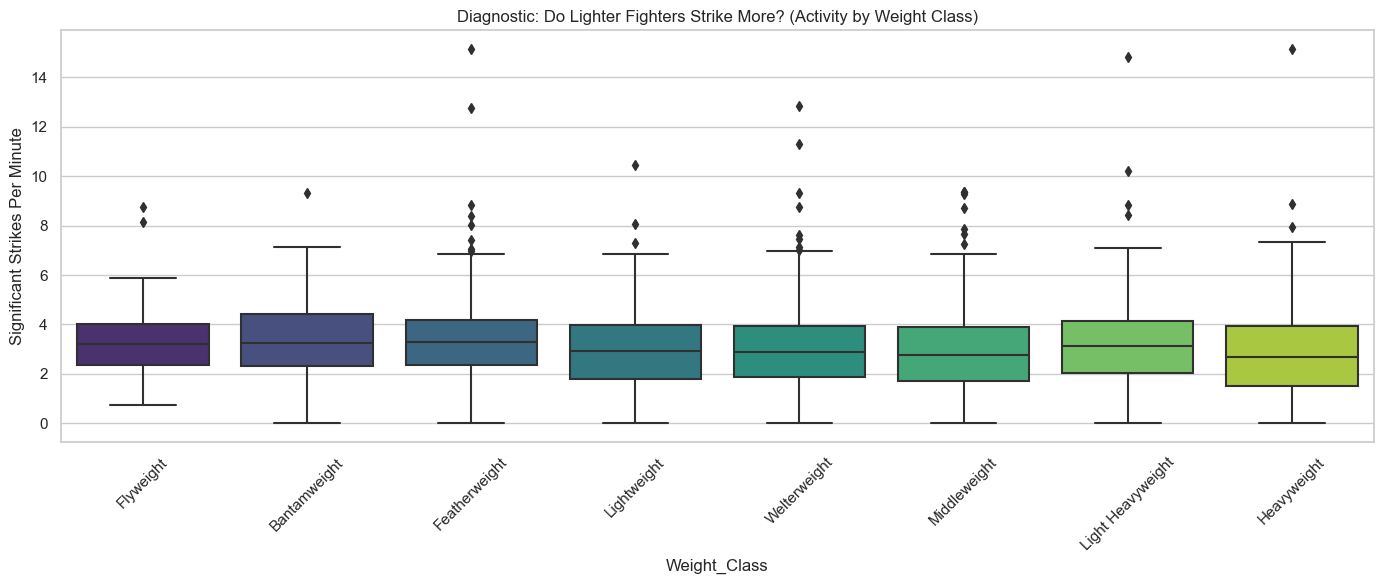

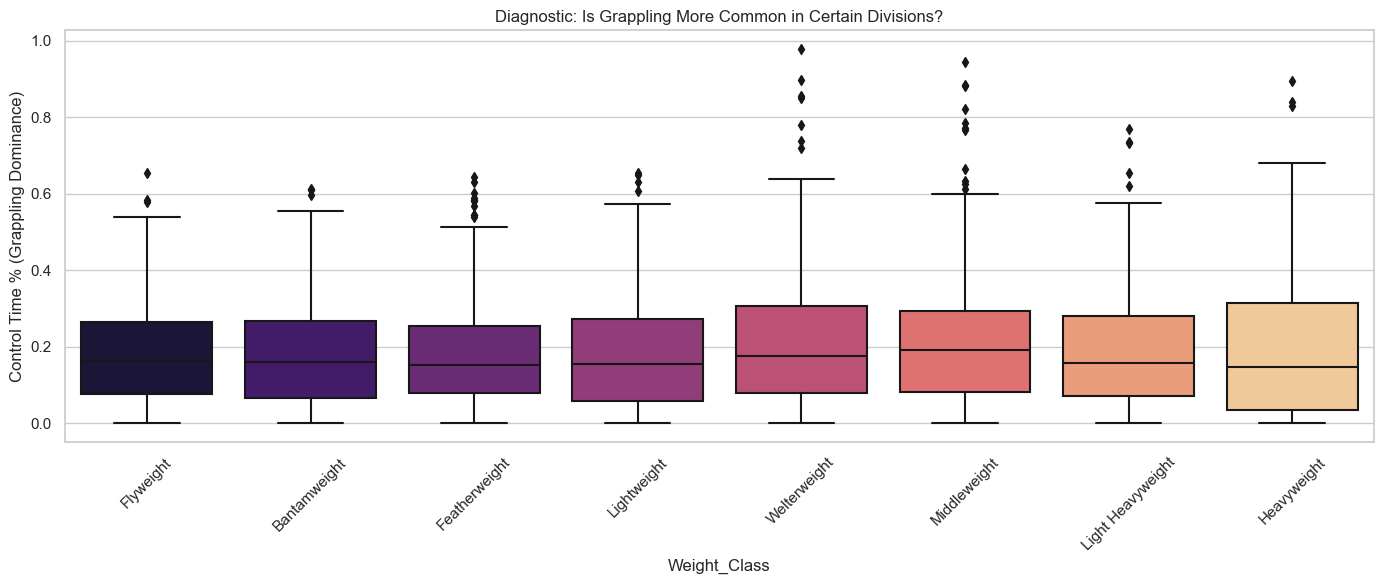

Generating Experience diagnostics...


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

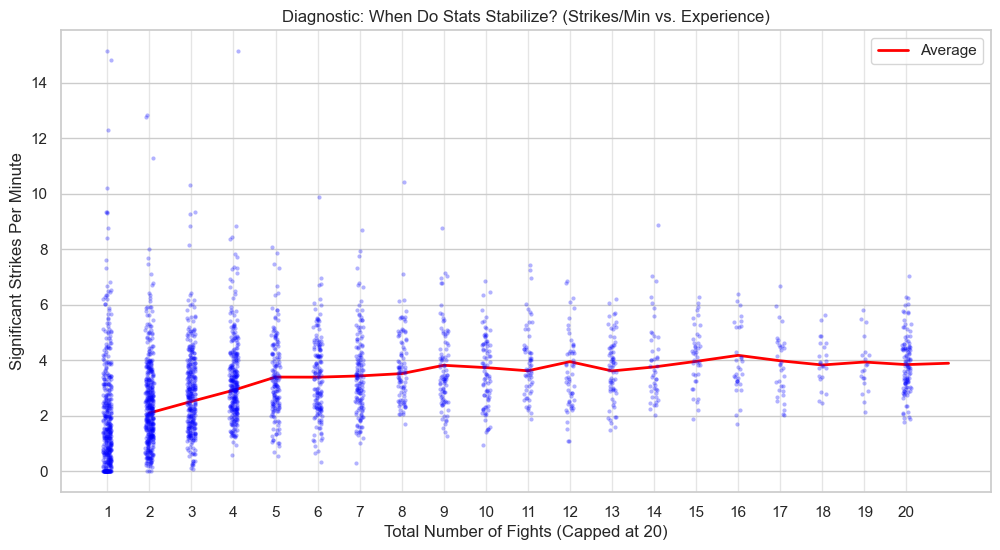


--- INTERPRETATION GUIDE ---
1. WEIGHT: If boxplots are at different heights (staircase pattern), set NORMALIZE_WEIGHT = True.
2. EXPERIENCE: Look at the scatterplot. If x=1 and x=2 have massive spread compared to x=5,
   set MIN_FIGHTS = 3 or 5 in the next script.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Config
# We need the fighter features AND the raw fight data for weight class context
FEATURES_PATH = '../data/processed/ufc_fighter_style_features.csv'
CLEANED_FIGHTS_PATH = '../data/processed/ufc_fight_stats_cleaned.csv'

sns.set_theme(style="whitegrid")

# Load Data
if os.path.exists(FEATURES_PATH) and os.path.exists(CLEANED_FIGHTS_PATH):
    print("Loading datasets...")
    df_features = pd.read_csv(FEATURES_PATH)
    df_fights = pd.read_csv(CLEANED_FIGHTS_PATH)
    
    # Merge Weight Class into the Features. For simplicity, using the most recent class
    print("Merging weight classes...")
    fighter_weights = df_fights.groupby('Fighter')['Weight_Class'].agg(
        lambda x: x.mode()[0] if len(x.mode()) > 0 else "Unknown"
    ).reset_index()
    
    df_merged = df_features.merge(fighter_weights, on='Fighter')
    
    # Filter for main distinct weight classes to keep the plot clean
    main_classes = ['Flyweight', 'Bantamweight', 'Featherweight', 'Lightweight', 
                    'Welterweight', 'Middleweight', 'Light Heavyweight', 'Heavyweight']
    
    # Create a subset for plotting (removing Catchweight/Unknown)
    df_plot = df_merged[df_merged['Weight_Class'].isin(main_classes)].copy()

    # Set order from lightest to heaviest
    class_order = main_classes 


    # PART 1: WEIGHT CLASS BIAS CHECK
    print("Generating Weight Class diagnostics...")
    
    # Plot 1: The "Pace" Problem (Strikes Per Minute)
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Weight_Class', y='Sig_Str_PM', data=df_plot, order=class_order, palette='viridis')
    plt.title("Diagnostic: Do Lighter Fighters Strike More? (Activity by Weight Class)")
    plt.xticks(rotation=45)
    plt.ylabel("Significant Strikes Per Minute")
    plt.tight_layout()
    plt.show()

    # Plot 2: The "Grappling" Meta (Control Ratio)
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Weight_Class', y='Control_Ratio', data=df_plot, order=class_order, palette='magma')
    plt.title("Diagnostic: Is Grappling More Common in Certain Divisions?")
    plt.xticks(rotation=45)
    plt.ylabel("Control Time % (Grappling Dominance)")
    plt.tight_layout()
    plt.show()


    # PART 2: THE "SAMPLE SIZE" CHECK
    print("Generating Experience diagnostics...")
    
    # Goal: Find the "minimum fights" threshold where variance stabilizes
    plt.figure(figsize=(12, 6))

    # Capping the x-axis at 20 fights so the chart is readable
    df_merged['Fights_Capped'] = df_merged['Total_Fights'].apply(lambda x: x if x <= 20 else 20)

    # Plot the spread of "Striking Output" for each experience level
    # Use jitter to see the density of points
    sns.stripplot(x='Fights_Capped', y='Sig_Str_PM', data=df_merged, 
                  alpha=0.3, jitter=True, color='blue', s=3)

    # Add a red line for the average to see if it drifts
    mean_vals = df_merged.groupby('Fights_Capped')['Sig_Str_PM'].mean()
    sns.lineplot(x=mean_vals.index, y=mean_vals.values, color='red', label='Average', linewidth=2)

    plt.title("Diagnostic: When Do Stats Stabilize? (Strikes/Min vs. Experience)")
    plt.xlabel("Total Number of Fights (Capped at 20)")
    plt.ylabel("Significant Strikes Per Minute")
    plt.legend()
    plt.grid(True, axis='x', alpha=0.5)
    plt.show()

    print("\nINTERPRETATION GUIDE")
    print("1. WEIGHT: If boxplots are at different heights (staircase pattern), set NORMALIZE_WEIGHT = True.")
    print("2. EXPERIENCE: Look at the scatterplot. If x=1 and x=2 have massive spread compared to x=5, set MIN_FIGHTS = 3 or 5 in the next script.")

else:
    print("Files not found. Make sure you ran 01_data_cleaning.ipynb and 02_feature_engineering.ipynb!")